# 대회 소개

### National Data Science Bowl
**Predict ocean health, one plankton at a time**  
https://www.kaggle.com/c/datasciencebowl

---

***Description***

Plankton are critically important to our ecosystem, accounting for more than half the primary productivity on earth and nearly half the total carbon fixed in the global carbon cycle. They form the foundation of aquatic food webs including those of large, important fisheries. Loss of plankton populations could result in ecological upheaval as well as negative societal impacts, particularly in indigenous cultures and the developing world. Plankton’s global significance makes their population levels an ideal measure of the health of the world’s oceans and ecosystems.

Traditional methods for measuring and monitoring plankton populations are time consuming and cannot scale to the granularity or scope necessary for large-scale studies. Improved approaches are needed. One such approach is through the use of an underwater imagery sensor. This towed, underwater camera system captures microscopic, high-resolution images over large study areas. The images can then be analyzed to assess species populations and distributions.

Manual analysis of the imagery is infeasible – it would take a year or more to manually analyze the imagery volume captured in a single day. Automated image classification using machine learning tools is an alternative to the manual approach. Analytics will allow analysis at speeds and scales previously thought impossible. The automated system will have broad applications for assessment of ocean and ecosystem health.

The National Data Science Bowl challenges you to build an algorithm to automate the image identification process. Scientists at the Hatfield Marine Science Center and beyond will use the algorithms you create to study marine food webs, fisheries, ocean conservation, and more. This is your chance to contribute to the health of the world’s oceans, one plankton at a time.

---

In [1]:
import numpy as np 
import pandas as pd 
import zipfile
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/datasciencebowl/plankton_identification.pdf
/kaggle/input/datasciencebowl/train.zip
/kaggle/input/datasciencebowl/sampleSubmission.csv.zip
/kaggle/input/datasciencebowl/test.zip


---

## 데이터 불러오기

* train, test 데이터가 zip으로 압축되어 있으므로 먼저 압축을 풀어주자.

In [2]:
with zipfile.ZipFile('/kaggle/input/datasciencebowl/train.zip','r') as z:
    z.extractall('train')
    
with zipfile.ZipFile('/kaggle/input/datasciencebowl/test.zip','r') as z:
    z.extractall('test')

### Train Dataset

* Train 데이터프레임을 만들어 주기

In [3]:
train = glob.glob('train/*/*/*')
train_df = pd.DataFrame({'path' : train})
train_df['image'] = train_df['path'].apply(lambda x : x.split('/')[-1])
train_df['label'] = train_df['path'].apply(lambda x : x.split('/')[-2])
train_df

,path,image,label
0,train/train/pteropod_theco_dev_seq/36451.jpg,36451.jpg,pteropod_theco_dev_seq
1,train/train/pteropod_theco_dev_seq/44793.jpg,44793.jpg,pteropod_theco_dev_seq
2,train/train/pteropod_theco_dev_seq/157712.jpg,157712.jpg,pteropod_theco_dev_seq
3,train/train/pteropod_theco_dev_seq/4992.jpg,4992.jpg,pteropod_theco_dev_seq
4,train/train/pteropod_theco_dev_seq/144126.jpg,144126.jpg,pteropod_theco_dev_seq
...,...,...,...
30331,train/train/hydromedusae_shapeB/27912.jpg,27912.jpg,hydromedusae_shapeB
30332,train/train/hydromedusae_shapeB/49210.jpg,49210.jpg,hydromedusae_shapeB
30333,train/train/hydromedusae_shapeB/114615.jpg,114615.jpg,hydromedusae_shapeB
30334,train/train/hydromedusae_shapeB/81391.jpg,81391.jpg,hydromedusae_shapeB


## Test Dataset

* Test 데이터 프레임을 만들어 주기

In [4]:
test = glob.glob('./test/*/*')
test_df = pd.DataFrame({'path' : test})
test_df['image'] = test_df['path'].apply(lambda x : x.split('/')[-1])
test_df

,path,image
0,./test/test/105188.jpg,105188.jpg
1,./test/test/27651.jpg,27651.jpg
2,./test/test/11940.jpg,11940.jpg
3,./test/test/87538.jpg,87538.jpg
4,./test/test/95396.jpg,95396.jpg
...,...,...
130395,./test/test/34122.jpg,34122.jpg
130396,./test/test/88776.jpg,88776.jpg
130397,./test/test/78514.jpg,78514.jpg
130398,./test/test/1830.jpg,1830.jpg


---

## 데이터 확인하기

* 이미지 모양 및 크기 확인
* class 개수 및 분포 확인

### 이미지 확인하기

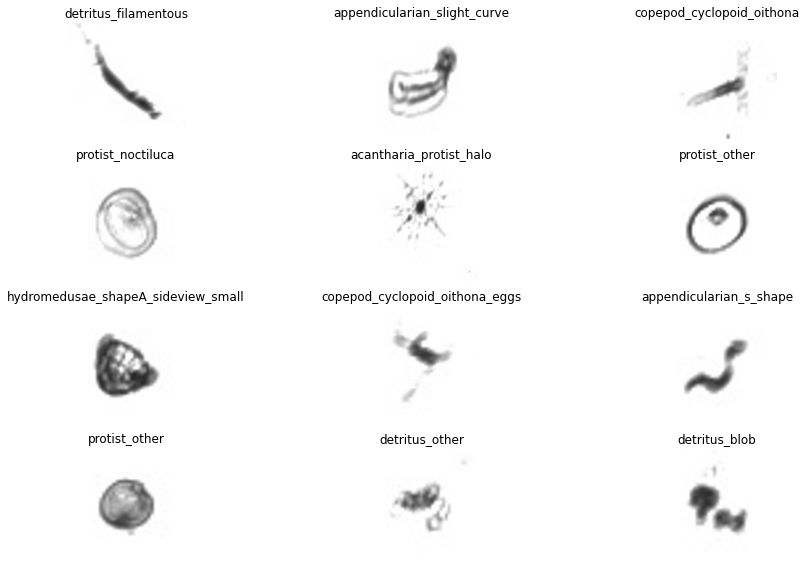

In [5]:
fig , axes = plt.subplots(4,3)
fig.set_size_inches(15,10)

for index in range(0,12):
    idx = random.randrange(len(train_df))
    img = Image.fromarray(cv2.imread(train_df.iloc[idx,0], cv2.IMREAD_COLOR)).resize((256,256))
    axes[index//3 , index%3].imshow(img)
    axes[index//3 , index%3].set_title(train_df['label'][idx])
    axes[index//3,  index%3].axis('off')

### 샘플 이미지 사이즈 확인하기

Image size:  (131, 251)


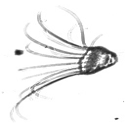

In [6]:
sample_image = Image.open(train[1000])
print("Image size: ",sample_image.size)
sample_image.resize((128,128))

### Train Dataset 이미지들의 평균 너비 및 높이

In [7]:
w = []
h = []
idx=0
for i in train:
    img = Image.open(i)
    w.append(img.size[0])
    h.append(img.size[1])
    img.close()
    idx+=1
    
print("Train Images' mean width :",np.mean(w),"\nTrain Images' mean height :",np.mean(h))

Train Images' mean width : 73.50728507383967 
Train Images' mean height : 66.66182093881856


### Label의 분포

The unique label numbers : 121


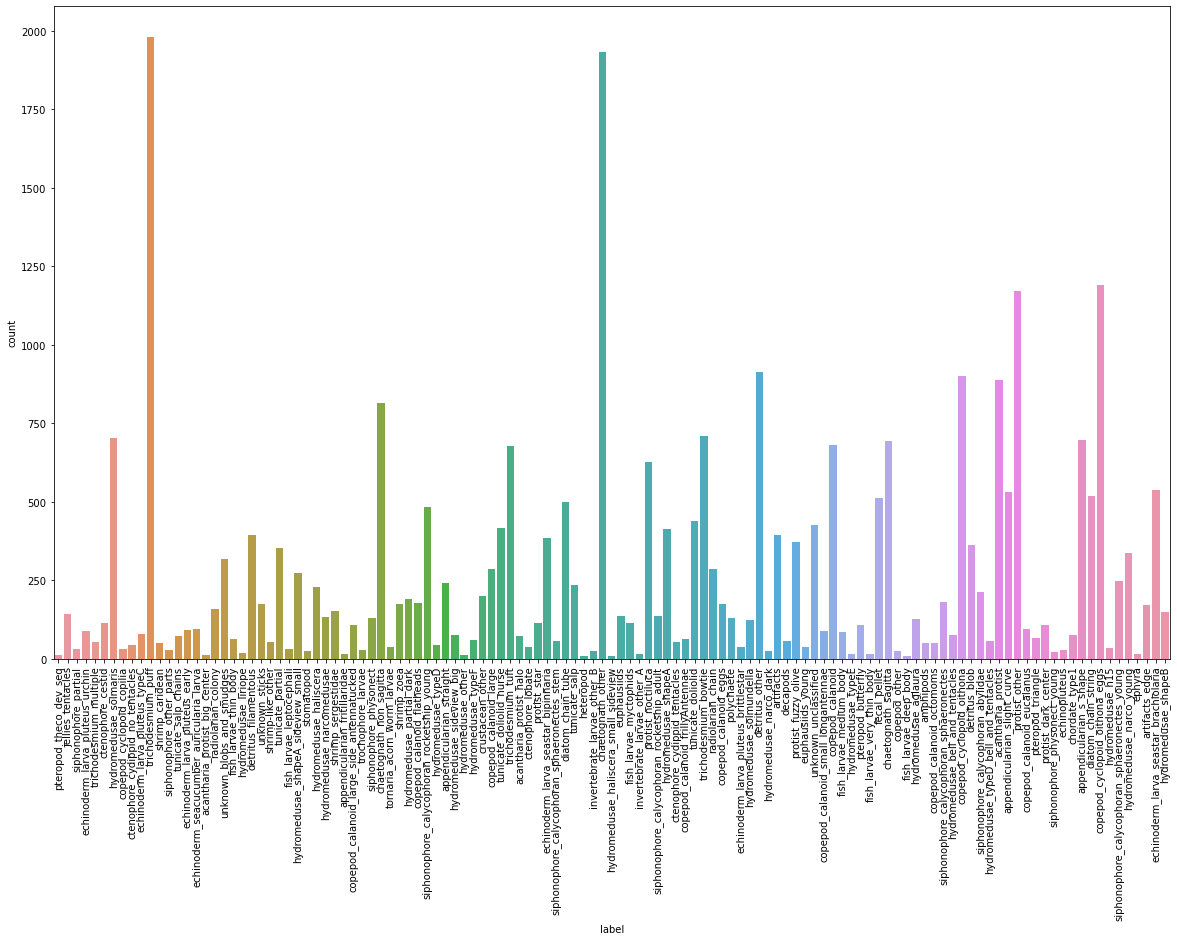

In [8]:
print("The unique label numbers :",train_df['label'].nunique())

a,b = plt.subplots(1,1,figsize=(20,12))
plot = sns.countplot(train_df['label'])
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

* 각 `label` 별로 데이터의 분포가 다르다.

---

## Test Dataset 전처리

In [17]:
idg_test = ImageDataGenerator()

test_generator = idg_test.flow_from_dataframe(test_df, 
                                                x_col = 'path',
                                                y_col = None, 
                                                class_mode = None,
                                                shuffle=False,
                                                batch_size = 64,
                                                target_size = (150,150),)

Found 130400 validated image filenames.


---

## 교차 검증으로 모델 학습하기

In [15]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
result=0
index=0

for train_index, valid_index in k_fold.split(train_df, train_df['label']):
    
    X_train = train_df.iloc[train_index]
    X_val = train_df.iloc[valid_index]
    
    idg_train = ImageDataGenerator(horizontal_flip=True)
    idg_val = ImageDataGenerator()
    
    train_generator = idg_train.flow_from_dataframe(X_train, 
                                                x_col = 'path',
                                                y_col = 'label', 
                                                batch_size = 64,
                                                target_size = (150,150))

    val_generator = idg_val.flow_from_dataframe(X_val, 
                                                x_col = 'path',
                                                y_col = 'label', 
                                                batch_size = 64,
                                                target_size = (150,150))    
    
    model = Sequential()
    model.add(EfficientNetB1(include_top = False,weights ='imagenet', pooling = 'avg'))
    model.add(Dense(121, activation = 'softmax'))


    model.compile(optimizer = tf.keras.optimizers.Adam() , loss = 'categorical_crossentropy', metrics = ['acc'],)

    es = EarlyStopping(patience = 10, verbose = True)
    ckpt = ModelCheckpoint('best.h5', save_best_only = True, verbose =True, monitor = 'val_loss')
    rl = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = True)

    model.fit(train_generator, 
              validation_data = val_generator,
              callbacks = [ckpt, rl, es], 
              epochs =25)

    model.load_weights('best.h5')
    
    result += model.predict(test_generator, verbose=True) / 5
    
    index+=1
    print(f"\n\n{index} 번째 교차 검증 완료 ... ... ...\n\n")

Found 24268 validated image filenames belonging to 121 classes.
Found 6068 validated image filenames belonging to 121 classes.
Epoch 1/25
380/380 [==============================] - ETA: 0s - loss: 1.5005 - acc: 0.5914
Epoch 00001: val_loss improved from inf to 1.13858, saving model to best.h5
380/380 [==============================] - 117s 308ms/step - loss: 1.5005 - acc: 0.5914 - val_loss: 1.1386 - val_acc: 0.6660
Epoch 2/25
380/380 [==============================] - ETA: 0s - loss: 0.8996 - acc: 0.7200
Epoch 00002: val_loss improved from 1.13858 to 0.95202, saving model to best.h5
380/380 [==============================] - 113s 298ms/step - loss: 0.8996 - acc: 0.7200 - val_loss: 0.9520 - val_acc: 0.7104
Epoch 3/25
380/380 [==============================] - ETA: 0s - loss: 0.7349 - acc: 0.7634
Epoch 00003: val_loss improved from 0.95202 to 0.92019, saving model to best.h5
380/380 [==============================] - 114s 301ms/step - loss: 0.7349 - acc: 0.7634 - val_loss: 0.9202 - val_a

Epoch 18/25
380/380 [==============================] - ETA: 0s - loss: 0.0285 - acc: 0.9933
Epoch 00018: val_loss did not improve from 0.94551
380/380 [==============================] - 112s 296ms/step - loss: 0.0285 - acc: 0.9933 - val_loss: 1.0917 - val_acc: 0.7605
Epoch 19/25
380/380 [==============================] - ETA: 0s - loss: 0.0262 - acc: 0.9943
Epoch 00019: val_loss did not improve from 0.94551
380/380 [==============================] - 112s 295ms/step - loss: 0.0262 - acc: 0.9943 - val_loss: 1.0954 - val_acc: 0.7625
Epoch 20/25
380/380 [==============================] - ETA: 0s - loss: 0.0260 - acc: 0.9948
Epoch 00020: val_loss did not improve from 0.94551

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
380/380 [==============================] - 112s 294ms/step - loss: 0.0260 - acc: 0.9948 - val_loss: 1.1000 - val_acc: 0.7620
Epoch 00020: early stopping
2038/2038 [==============================] - 107s 52ms/step


3 번째 교차 검증 완료 ... ... ..

Epoch 10/25
380/380 [==============================] - ETA: 0s - loss: 0.1549 - acc: 0.9487
Epoch 00010: val_loss improved from 0.93879 to 0.93774, saving model to best.h5
380/380 [==============================] - 113s 299ms/step - loss: 0.1549 - acc: 0.9487 - val_loss: 0.9377 - val_acc: 0.7620
Epoch 11/25
380/380 [==============================] - ETA: 0s - loss: 0.0977 - acc: 0.9692
Epoch 00011: val_loss did not improve from 0.93774
380/380 [==============================] - 112s 294ms/step - loss: 0.0977 - acc: 0.9692 - val_loss: 0.9543 - val_acc: 0.7645
Epoch 12/25
380/380 [==============================] - ETA: 0s - loss: 0.0739 - acc: 0.9796
Epoch 00012: val_loss did not improve from 0.93774
380/380 [==============================] - 112s 295ms/step - loss: 0.0739 - acc: 0.9796 - val_loss: 0.9785 - val_acc: 0.7618
Epoch 13/25
380/380 [==============================] - ETA: 0s - loss: 0.0572 - acc: 0.9852
Epoch 00013: val_loss did not improve from 0.93774
380/380 [===============

---

## 제출

* sampleSubmission.csv를 열어서 column의 순서를 확인해보면, 알파벳 순서로 들어가 있지 않다. 
* result 칼럼의 순서와도 맞지 않으니, 이런 겨웅 직접 제출 파일을 만드는 것이 더 쉽다.

In [19]:
with zipfile.ZipFile('/kaggle/input/datasciencebowl/sampleSubmission.csv.zip','r') as z:
    z.extractall('sub')

sub = pd.read_csv("sub/sampleSubmission.csv")
sub

,image,acantharia_protist_big_center,acantharia_protist_halo,acantharia_protist,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts_edge,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid_nurse,tunicate_doliolid,tunicate_partial,tunicate_salp_chains,tunicate_salp,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,1.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
1,10.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
2,100.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
3,1000.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
4,10000.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130395,99994.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
130396,99995.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
130397,99996.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
130398,99997.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264


In [20]:
col_names = list(sub.columns[1:])
col_names.sort()
col_names

['acantharia_protist',
 'acantharia_protist_big_center',
 'acantharia_protist_halo',
 'amphipods',
 'appendicularian_fritillaridae',
 'appendicularian_s_shape',
 'appendicularian_slight_curve',
 'appendicularian_straight',
 'artifacts',
 'artifacts_edge',
 'chaetognath_non_sagitta',
 'chaetognath_other',
 'chaetognath_sagitta',
 'chordate_type1',
 'copepod_calanoid',
 'copepod_calanoid_eggs',
 'copepod_calanoid_eucalanus',
 'copepod_calanoid_flatheads',
 'copepod_calanoid_frillyAntennae',
 'copepod_calanoid_large',
 'copepod_calanoid_large_side_antennatucked',
 'copepod_calanoid_octomoms',
 'copepod_calanoid_small_longantennae',
 'copepod_cyclopoid_copilia',
 'copepod_cyclopoid_oithona',
 'copepod_cyclopoid_oithona_eggs',
 'copepod_other',
 'crustacean_other',
 'ctenophore_cestid',
 'ctenophore_cydippid_no_tentacles',
 'ctenophore_cydippid_tentacles',
 'ctenophore_lobate',
 'decapods',
 'detritus_blob',
 'detritus_filamentous',
 'detritus_other',
 'diatom_chain_string',
 'diatom_chain_

In [22]:
my_sub = pd.concat([test_df,pd.DataFrame(result, columns=col_names)], axis=1).drop(['path'], axis=1)
my_sub

,image,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,105188.jpg,3.407894e-05,5.234519e-07,4.727002e-07,2.523708e-05,6.414000e-07,1.429394e-04,7.389794e-05,2.510147e-05,8.997078e-08,...,2.137576e-05,2.115729e-06,1.604188e-06,8.190606e-06,1.233781e-06,2.818242e-06,1.334955e-06,0.000023,7.377646e-05,0.000072
1,27651.jpg,2.613361e-06,2.237140e-07,1.978252e-06,6.420553e-07,1.818773e-06,1.416835e-05,8.689414e-06,2.637850e-07,2.187041e-08,...,2.810447e-07,9.286011e-07,8.374320e-06,2.925759e-06,2.006822e-07,2.315101e-07,7.389501e-07,0.000014,2.626070e-06,0.000423
2,11940.jpg,6.104551e-06,2.521627e-06,2.513692e-07,4.636616e-05,2.085026e-06,1.489576e-05,8.225787e-05,1.137621e-05,3.021312e-07,...,1.476521e-05,7.298316e-07,1.122896e-06,1.197497e-04,4.583527e-07,1.900000e-05,4.955790e-07,0.000482,3.988420e-05,0.002802
3,87538.jpg,1.197881e-05,4.275779e-06,1.933437e-05,3.641628e-03,1.369998e-03,2.135313e-04,4.967969e-04,7.344080e-04,8.830065e-06,...,1.323840e-01,8.188009e-06,6.234657e-04,2.646256e-04,5.426758e-05,1.694718e-03,1.481177e-05,0.000878,4.522099e-02,0.106003
4,95396.jpg,1.079931e-07,1.477846e-06,4.025902e-07,9.353130e-05,6.802826e-07,3.575570e-06,4.541085e-07,1.869251e-07,2.157424e-07,...,3.714577e-06,4.525396e-07,1.575890e-07,7.061017e-07,1.216337e-06,4.131224e-07,3.218001e-07,0.000011,8.910469e-07,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130395,34122.jpg,9.404398e-06,4.410570e-06,1.469415e-05,4.892956e-04,4.235670e-04,7.620276e-04,7.704680e-05,4.103683e-05,1.476081e-05,...,1.900832e-04,1.661727e-05,9.112542e-02,4.120418e-04,3.442946e-04,3.249257e-04,1.036034e-05,0.033025,1.140596e-05,0.008211
130396,88776.jpg,1.188530e-04,3.108746e-06,7.981415e-06,2.125595e-07,5.005016e-08,5.221577e-07,6.974371e-07,1.526524e-06,1.525192e-05,...,7.819511e-01,6.797829e-07,2.360160e-07,1.453742e-07,5.104931e-06,3.599948e-06,5.606108e-07,0.000010,1.053775e-04,0.000017
130397,78514.jpg,3.513707e-06,1.072021e-07,6.263767e-07,2.130197e-07,8.390234e-07,3.240724e-05,1.973183e-04,1.500386e-04,1.360382e-08,...,1.262665e-07,2.861952e-08,2.094702e-04,1.114861e-06,8.004471e-07,1.075251e-05,1.032177e-07,0.000038,1.695668e-06,0.000293
130398,1830.jpg,2.687246e-08,6.054729e-10,1.001864e-07,2.510690e-08,9.267259e-09,2.659469e-08,6.407049e-08,6.902572e-08,9.994848e-01,...,1.325866e-07,2.992527e-09,6.681008e-08,9.846344e-09,9.125281e-08,4.204970e-09,2.354498e-08,0.000091,7.961059e-08,0.000001


In [23]:
my_sub.to_csv('bowl_sub.csv',index=False) # Evaluation : Log Loss 0.65988 35/1,049